In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pydub import AudioSegment

import IPython.display as ipd
from IPython.display import display

import librosa as lr
from librosa import load as lr_load
from librosa import amplitude_to_db
from librosa.feature import melspectrogram, mfcc, chroma_stft, spectral_flatness, zero_crossing_rate, tempogram
from librosa.beat import tempo, beat_track
from librosa.feature import spectral_contrast as lf_spectral_contrast
from librosa.feature import spectral_rolloff as lf_spectral_rolloff
from librosa import pyin, amplitude_to_db

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.io import wavfile
from scipy.spatial.distance import euclidean, cityblock

C:\Users\molie\miniconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
class AudioFeatureExtractor:
    """
    A class for extracting various audio features from an audio signal.

    Attributes:
        None

    Methods:
        mfccs(data, sfreq):
            Extracts Mel-Frequency Cepstral Coefficients (MFCCs) from the audio signal.

        calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
            Calculates spectrograms from a list of audio clips.

        calculate_spectral_features(spectrograms):
            Calculates spectral features (bandwidth and centroid) from a list of spectrograms.

        calculate_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
            Calculates spectral contrast from the audio signal.

        calculate_tonnetz(data, sr):
            Calculates tonnetz features from the audio signal.

        calculate_spectral_rolloff(data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
            Calculates spectral rolloff from the audio signal.

        calculate_chroma_features(data, sr, n_fft=2048, hop_length=512):
            Calculates chroma features from the audio signal.

        calculate_mel_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
            Calculates mel spectrogram and its contrast from the audio signal.

        calculate_spectral_flatness(data, sr, n_fft=2048, hop_length=512):
            Calculates spectral flatness from the audio signal.

        zero_crossing_rate_features(data, n_fft=2048, hop_length=512):
            Calculates zero-crossing rate from the audio signal.

        rms_energy_features(data):
            Calculates root mean square (RMS) energy from the audio signal.
    """

    def __init__(self):
        pass

    def mfccs(self, data, sr):
        """
        Extracts Mel-Frequency Cepstral Coefficients (MFCCs) from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.

        Returns:
            dict: A dictionary containing the mean of each MFCC coefficient.
        """
        mfcc_result = mfcc(y=data, sr=sr)
        datadict = {}
        for var in range(len(mfcc_result)):
            datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc_result[var, :])
        return datadict

    def calculate_spectrograms(self, audio_clips, n_fft=2048, hop_length=512, win_length=None):
        """
        Calculates spectrograms from a list of audio clips.

        Parameters:
            audio_clips (list): List of audio clips.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.
            win_length (int): The length of the windowing segments.

        Returns:
            tuple: Two lists - spectrograms and their corresponding dB-scaled versions.
        """
        spectrograms = []
        spectrograms_db = []

        for clip in audio_clips:
            stft_matrix = lr.stft(y=clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
            spectrogram = np.abs(stft_matrix)
            spec_db = amplitude_to_db(S=spectrogram, ref=np.max)
            spectrograms.append(spectrogram)
            spectrograms_db.append(spec_db)
        return spectrograms, spectrograms_db

    def calculate_spectral_features(self, spectrograms):
        """
        Calculates spectral features (bandwidth and centroid) from a list of spectrograms.

        Parameters:
            spectrograms (list): List of spectrograms.

        Returns:
            tuple: Two lists - spectral bandwidths and centroids.
        """
        bandwidths = []
        centroids = []

        for spectrogram in spectrograms:
            spec_bw = lr.feature.spectral_bandwidth(S=spectrogram)
            spec_cn = lr.feature.spectral_centroid(S=spectrogram)
            bandwidths.append(spec_bw)
            centroids.append(spec_cn)
        return bandwidths, centroids

    def calculate_spectral_contrast(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates spectral contrast from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral contrast features.
        """
        datadict = {}
        spectral_contrast = lr.feature.spectral_contrast(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        for var in range(len(spectral_contrast)):
            datadict[f'spectral_contrast{var + 1}_mean'] = np.mean(spectral_contrast[var, :])
        return datadict

    def calculate_tonnetz(self, data, sr):
        """
        Calculates tonnetz features from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.

        Returns:
            numpy.ndarray: Tonnetz features.
        """
        tonnetz = lr.feature.tonnetz(y=data, sr=sr)
        datadict = {}
        for var in range(len(tonnetz)):
            datadict[f'tonnetz{var + 1}_mean'] = np.mean(tonnetz[var, :])
        return datadict

    def calculate_spectral_rolloff(self, data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
        """
        Calculates spectral rolloff from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            roll_percent (float): Percentage for determining rolloff.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral rolloff features.
        """
        spectral_rolloff = lr.feature.spectral_rolloff(y=data, sr=sr, roll_percent=roll_percent, n_fft=n_fft, hop_length=hop_length)
        return spectral_rolloff

    def calculate_chroma_features(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates chroma features from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Chroma features.
        """
        chromagram = chroma_stft(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        datadict = {}
        for var in range(len(chromagram)):
            datadict[f'chromagram{var + 1}_mean'] = np.mean(chromagram[var, :])
        return datadict

    def calculate_mel_spectral_contrast(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates mel spectrogram and its contrast from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Mel spectrogram contrast features.
        """
        mel_spectrogram = melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        mel_spectral_contrast = lr.feature.spectral_contrast(S=mel_spectrogram)
        datadict = {}
        for var in range(len(mel_spectral_contrast)):
            datadict[f'mel_spectral_contrast{var + 1}_mean'] = np.mean(mel_spectral_contrast[var, :])
        return datadict

    def calculate_spectral_flatness(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates spectral flatness from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral flatness features.
        """
        flatness = lr.feature.spectral_flatness(y=data, n_fft=n_fft, hop_length=hop_length)
        return flatness

    def zero_crossing_rate_features(self, data, n_fft=2048, hop_length=512):
        """
        Calculates zero-crossing rate from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Zero-crossing rate features.
        """
        zcr = zero_crossing_rate(y=data, frame_length=n_fft, hop_length=hop_length)
        return zcr

    def rms_energy_features(self, data):
        """
        Calculates root mean square (RMS) energy from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.

        Returns:
            numpy.ndarray: RMS energy features.
        """
        rms_energy = lr.feature.rms(y=data)[0]
        return rms_energy

# Mel-Frequency Cepstral Coefficients (MFCCs) Calculation

1. **Framing:**
   $ x_w[n] = x[n] \cdot w[n] $

2. **Fast Fourier Transform (FFT):**
   $ X(k) = \text{FFT}(x_w[n]) $

3. **Mel Filterbank:**
   $ S_m = \sum_{k=0}^{N-1} |X(k)|^2 \cdot H_m(k) $

4. **Logarithmic Scaling:**
   $ M_m = \log(S_m) $

5. **Discrete Cosine Transform (DCT):**
   $ C_l = \sum_{m=0}^{M-1} \cos\left(\frac{\pi l (2m + 1)}{2M}\right) \cdot M_m $

   Symbols:
   - $ x[n] $: Audio signal.
   - $ w[n] $: Hamming window.
   - $ X(k) $: Result of the FFT.
   - $ H_m(k) $: $m$-th Mel filter.
   - $ S_m $: Energy in the $m$-th Mel filter.
   - $ M_m $: Log-Mel energy.
   - $ C_l $: $l$-th MFCC coefficient.
   - $ N $: Number of frequency points after FFT.
   - $ M $: Number of Mel filters.
   - $ L $: Number of desired MFCCs.

# 1. Fast Fourier Transform (FFT):
Explanation:
The Fast Fourier Transform (FFT) is an efficient algorithm for computing the Discrete Fourier Transform (DFT). It's like a speedy way to analyze the frequency content of a signal. Instead of taking a long time to calculate the DFT manually, the FFT quickly breaks down a sequence of data points into its frequency components.

Example:
Imagine you have a digital signal representing the vibrations of a guitar string over time. Applying the FFT allows you to rapidly identify the specific musical frequencies present in the sound. If the guitar string produces a clear note at a particular frequency, the FFT would efficiently highlight that frequency, making it easier to recognize the musical pitch and analyze the harmonic structure of the guitar sound.

# 2. Mel Filterbanks:
Explanation:
Mel Filterbanks are filters used in audio processing and speech recognition to mimic the human ear.

Example:
Consider an audio clip of someone playing a guitar. Using Mel Filterbanks, you can capture the essential features of the guitar sound that our ears find important. These filters might emphasize the frequency bands corresponding to the unique tones produced by the guitar strings.

# 3. Inverse Discrete Cosine Transform (IDCT):
Explanation:
The Inverse Discrete Cosine Transform (IDCT) is used to convert frequency domain information back to the time domain. It is often applied in image compression, where the image is transformed into the frequency domain using the Discrete Cosine Transform (DCT) for compression and then reconstructed back using the IDCT. It is often used with FFTs.

Example:
Think of a digital image of a sunset. The image can be compressed using the Discrete Cosine Transform (DCT). The IDCT would then be applied to reconstruct the compressed image. It's like taking a highly compressed version of the sunset image, applying the inverse transform, and getting back the detailed and colorful sunset picture we started with.

# Spectrogram
A spectrogram is like a musical timeline. It shows how loud different pitches are at every moment in a sound.

Example:
Think of a bird's song. A spectrogram would reveal when the bird sings high or low notes and how loud each part is throughout its melody. It's a way to visualize the musical story of the bird's song over time.

The spectrogram formula breakdown:

\[ S(f, t) = \left|X(f, t)\right|^2 \]

- $ S(f, t) $: Spectrogram, representing the magnitude of the spectral content at a specific frequency ($ f $) and time ($ t $).
- $ X(f, t) $: Fourier transform of the signal $ x(t) $ at frequency $ f $ and time $ t $, a complex number with amplitude and phase information.
- $ \left|X(f, t)\right| $: Magnitude (or modulus) of $ X(f, t) $, providing the amplitude of the signal at frequency $ f $ and time $ t $.
- $ \left|X(f, t)\right|^2 $: Square of the magnitude, yielding the power spectral density, a measure of signal power or energy at a specific frequency and time.

This formula is used to compute spectrograms, which visualize how the frequency content of a signal changes over time.

# Bandwidth:
Definition: Bandwidth measures how spread out the frequencies in a signal are. A broader bandwidth indicates a wider range of frequencies.

Its the maximum frequency (Fmax) minus (Fmin) the lowest frequency

# Centroid:
\[ C = \frac{\sum_{i} f_i \cdot A_i}{\sum_{i} A_i} \]

- $ C $: Centroid (average frequency).
- $ f_i $: Frequency of the $ i $-th component.
- $ A_i $: Amplitude (or magnitude) of the $ i $-th component.

Definition: Centroid represents the center of mass of the frequency distribution. It indicates where most of the energy in the spectrum is concentrated.
Its the average frequency.

# Tonnetz
Explanation:
Tonnetz is like a musical map, visually representing how different pitches or chords relate harmonically. Points close together on the hexagonal lattice indicate a strong harmonic connection.

Example:
Consider the chords A minor and E minor. In Tonnetz, they would be visually close, reflecting their harmonic compatibility. On the other hand, A minor and F# major might be farther apart, indicating a less harmonically related pair. Tonnetz simplifies the analysis of harmonic relationships in music.

# Spectral rolloff
the spectral rolloff is simply the frequency that splits the frequency below a certain percentage of the total spectral energy, usually this is at 85%
 The formula is given by:

\[ R = \frac{\sum_{f} S(f)}{\sum_{f} S(f_{\text{total}})} \cdot 100 \leq p \]

- $ R $: Spectral rolloff frequency.
- $ S(f) $: Spectral energy at frequency $ f $.
- $ S(f_{\text{total}}) $: Total spectral energy.
- $ p $: Percentage of total spectral energy (e.g., 85% or 95%).

# Chroma Features:

Chroma features provide insights into the pitch distribution in music, emphasizing tonal qualities. The chromagram has classes.

The chroma features are computed using the chromagram, where each chroma value (C_i) is calculated as:

\[ C_i = \sum_{j} \text{magnitude}(f_j) \]

- $ C_i $: Chroma value for the $ i $-th pitch class.
- $ \text{magnitude}(f_j) $: Magnitude of the $ j $-th frequency component in the spectrum.
- The summation is done over all frequency components that correspond to the $ i $-th pitch class.

This process is repeated for each of the twelve pitch classes to obtain the complete chroma features.

# Spectral Contrast

Spectral Contrast is a feature in audio signal processing that measures the difference in amplitude between peaks and valleys in a frequency spectrum. It helps capture the perceptual contrast between the spectral peaks and background noise, providing information about the tonal quality of the sound.

There is no common formula for spectral contrast.

# Spectral Flatness

Spectral Flatness, also known as tonality or flatness, is a measure of how tonal or noisy a sound is. A perfectly tonal sound (e.g., a sine wave) has high flatness, while a noisy sound has low flatness.

There is no common formula for spectral flatness.

# Zero-Crossing Rate:

Zero-Crossing Rate (ZCR) measures how often an audio signal changes its sign, reflecting its noisiness or tonality.

Formula: $ ZCR = \frac{\text{Number of zero-crossings}}{\text{Total number of samples} - 1} $

- The numerator is the count of times the signal changes sign (crosses zero).
- The denominator is the total number of samples minus one to account for the fact that zero-crossing rate is defined as the rate per sample.


# Tempogram

Tempogram shows the tempo or rhythmic characterisics of music. It provides a way to analyze the variations in tempo, beat, or rhythmic patterns within an audio signal.


The calculation of a tempogram involves computing the local autocorrelation of the audio signal at different time lags. The formula is somewhat complex and involves signal processing techniques, such as Fourier transforms.

$[ T(\tau) = \sum_{n=0}^{N-1} \text{Spec}(\omega_n) \cdot \text{Spec}^*(\omega_n, \tau) $]

- $[( T(\tau) $): Tempogram at time lag $( \tau $]).
- $[( \text{Spec}(\omega_n) $): Short-time Fourier transform of the audio signal at frequency $( \omega_n $]).
- $[( \text{Spec}^*(\omega_n, \tau) $): Complex conjugate of the short-time Fourier transform at frequency $( \omega_n $) and time lag $( \tau $]).
- The summation is done over the signal's discrete frequencies.

# Polyphonic pitch

Polyphonic pitch refers to the ability to identify and analyze multiple pitches in an signal

\[ P_{\text{polyphonic}}(t) = \{f_1, f_2, \ldots, f_n\} \]

- \( P_{\text{polyphonic}}(t) \): Set of identified pitches at time \( t \).
- \( f_1, f_2, \ldots, f_n \): Individual pitch frequencies within the polyphonic mixture.


In [70]:
csv_path = "labels_new.csv"
audio_directory_labeled = "labeled"
audio_directory_unlabeled = "unlabeled"

audio_extractor = AudioFeatureExtractor()
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

def process_audio_features(audio_directory, labeled=True, df=df):
    # Audio features storage
    audio_features_list = []

    # Set the target length for audio truncation or padding
    lengte = 30 * 22050

    audio_arrays = np.empty((len(os.listdir(audio_directory)), lengte))
    # Process each audio file
    for index, file in enumerate(os.listdir(audio_directory)):
        sr = lr.get_samplerate(f'{audio_directory}/{file}')
        if file.endswith(".wav"):
            # sr = lr.get_samplerate(file)
            file_path = os.path.join(audio_directory, file)
            data, sfreq = lr.load(file_path, sr=None)
            # Truncate or pad the audio
            if len(data) > lengte:
                # Truncate the data
                data = data[:lengte]
            elif len(data) < lengte:
                # Pad with zeros
                padding = lengte - len(data)
                data = np.pad(data, (0, padding), mode='constant')
            
            audio_arrays[index] = data
            
            # Extract MFCC features
            mfcc_features = audio_extractor.mfccs(data, sfreq)
            spectral_contrast_features = audio_extractor.calculate_spectral_contrast(data, sr)
            tonnetz_features = audio_extractor.calculate_tonnetz(data, sr)
            spectral_rolloff_feature = audio_extractor.calculate_spectral_rolloff(data, sr)
            chroma_features = audio_extractor.calculate_chroma_features(data, sr)
            mel_spectral_contrast_features = audio_extractor.calculate_mel_spectral_contrast(data, sr)
            spectral_flatness_feature = audio_extractor.calculate_spectral_flatness(data, sr)
            zero_crossing_feature = audio_extractor.zero_crossing_rate_features(data)
            rms_energy = audio_extractor.rms_energy_features(data)
            
       # Combine all features into a dictionary
            features_dict = {
                'filename': file, 
                **mfcc_features,
                'rms_energy': np.mean(rms_energy),
                **spectral_contrast_features,
                **tonnetz_features,
                'spectral_rolloff': np.mean(spectral_rolloff_feature[0]),
                **chroma_features,
                **mel_spectral_contrast_features,
                'spectral_flatness': np.mean(spectral_flatness_feature[0]),
                'zcr': np.mean(zero_crossing_feature[0])
            }
                # Append the features dictionary to the list
            audio_features_list.append(features_dict) 
            
    spectograms, spectogram_features = audio_extractor.calculate_spectrograms(audio_arrays)
    bandwidths, centroids = audio_extractor.calculate_spectral_features(spectograms)

    bandwiths = pd.DataFrame({'bandwith': [np.mean(bandwidth[0]) for bandwidth in bandwidths]})
    centroids = pd.DataFrame({'centroid': [np.mean(centroid[0]) for centroid in centroids]})
    # Convert the list of feature dictionaries to a DataFrame
    audio_features_df = pd.DataFrame(audio_features_list)
    audio_features_df = pd.concat([audio_features_df, bandwiths], axis=1)
    audio_features_df = pd.concat([audio_features_df, centroids], axis=1)
    # Merge the original DataFrame with the new features DataFrame based on the 'filename' column
    if labeled:
        audio_features_df = pd.merge(df, audio_features_df, on='filename', how='left')

    audio_features_df = audio_features_df.sort_values(by='filename')
    return audio_features_df

# Process audio features
labeled_df = process_audio_features(audio_directory_labeled)
display(labeled_df)

unlabeled_df = process_audio_features(audio_directory_unlabeled, labeled=False)
display(unlabeled_df)

,filename,genre,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mel_spectral_contrast2_mean,mel_spectral_contrast3_mean,mel_spectral_contrast4_mean,mel_spectral_contrast5_mean,mel_spectral_contrast6_mean,mel_spectral_contrast7_mean,spectral_flatness,zcr,bandwith,centroid
8,m00002.wav,jazz,-298.807953,112.078224,6.485770,28.386517,-6.764679,16.651894,-11.809684,12.746783,...,6.739004,17.720329,31.856210,37.582171,36.234603,42.188263,0.001252,0.051222,1919.917650,1451.498371
9,m00039.wav,reggae,-169.243668,110.447716,-8.553957,43.898697,0.266454,26.646509,-14.365674,13.026837,...,8.001072,15.869485,22.225069,29.004593,27.931632,43.075836,0.004306,0.072178,2019.252686,1811.358216
43,m00041.wav,pop,-18.854591,71.328522,-3.743232,-1.396592,0.710348,-1.049137,-1.052407,-0.249471,...,5.718698,13.057337,17.657730,23.827369,27.071292,18.570913,0.078506,0.152910,2992.192112,3111.061099
29,m00072.wav,disco,-69.599335,83.059570,-16.599524,0.119469,7.415704,0.769619,1.337008,4.690686,...,6.370224,12.197484,18.810620,25.720595,24.686535,23.377385,0.038270,0.120259,2709.990169,2625.095044
34,m00096.wav,disco,-91.886307,87.604057,-2.058175,34.285538,-18.153368,19.344702,-14.697328,17.116173,...,4.989545,15.582052,20.384724,25.294628,29.771765,46.579812,0.009796,0.115890,2486.020650,2550.135384
48,m00102.wav,classical,-436.842346,154.113205,-19.859339,20.183603,3.164743,0.446392,-6.530639,-4.603338,...,8.704671,18.088766,26.164080,36.452103,37.462534,35.556624,0.000976,0.066325,1517.856160,1173.931066
25,m00112.wav,reggae,-265.694977,80.615921,9.722023,36.657085,27.836796,12.086828,15.014476,15.116937,...,3.927251,15.154408,20.473471,26.257647,25.445807,24.486615,0.026549,0.060883,2595.217468,2113.391953
4,m00138.wav,reggae,-198.632797,102.413567,-10.031449,30.802383,-3.310606,20.276924,-5.637373,28.095631,...,8.111595,11.985461,21.690643,26.647311,26.212014,47.129611,0.005168,0.070323,2295.466240,1995.600514
5,m00192.wav,classical,-85.264992,118.423058,-31.472771,20.282015,-4.417709,6.922598,-10.950942,-1.620085,...,5.707315,9.457773,16.339001,23.798978,26.500622,37.537164,0.010484,0.111613,1965.028715,1878.774030
22,m00206.wav,hiphop,-92.591652,77.412682,-32.756371,54.596119,-13.199195,33.656281,-12.085772,28.015388,...,3.856905,11.629413,12.605242,16.697020,17.101189,52.441041,0.018014,0.157603,2295.456105,2735.795802


,filename,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,mel_spectral_contrast2_mean,mel_spectral_contrast3_mean,mel_spectral_contrast4_mean,mel_spectral_contrast5_mean,mel_spectral_contrast6_mean,mel_spectral_contrast7_mean,spectral_flatness,zcr,bandwith,centroid
0,m00003.wav,-82.501259,97.344116,-34.373585,71.405922,-3.283182,17.367373,-9.023832,16.011181,-19.003857,...,5.011253,13.892055,18.007974,21.183092,21.028454,58.034254,0.009073,0.120159,2070.908728,2254.451748
1,m00012.wav,-1.925410,72.695557,-32.789642,63.592033,-18.557953,25.872955,-13.854105,18.064384,-11.945406,...,6.322091,13.544996,16.113373,22.568365,18.241123,55.859045,0.026390,0.178119,2286.246872,2908.260266
2,m00013.wav,-287.520996,101.737930,-35.368999,41.282764,-12.745122,17.284992,-13.978298,16.311884,-5.599028,...,4.346955,16.482222,24.210026,32.560252,34.102601,59.447518,0.002209,0.123492,1865.851544,1953.012399
3,m00043.wav,-120.127808,91.287666,-38.794960,75.003784,-3.806012,22.666491,-8.123724,23.654573,-14.638494,...,4.574703,13.135090,15.795038,18.074718,19.134837,60.384607,0.008840,0.126103,2073.302486,2384.812610
4,m00044.wav,-437.525238,170.971405,7.386171,-3.108705,0.777301,-11.135056,-12.523806,-6.900928,-5.850053,...,4.602050,18.591778,23.050981,33.758989,36.850383,40.763202,0.000153,0.052112,899.979779,790.478225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,m00971.wav,-246.218369,149.443878,-41.973816,11.606412,-10.287585,-4.018404,-7.138946,-10.137027,-9.425965,...,6.321750,12.820653,17.553917,24.904399,30.941367,37.337512,0.006206,0.091588,1588.161024,1525.601266
101,m00973.wav,-8.531341,54.251755,20.963310,13.099079,9.721153,6.015052,10.720785,6.102119,0.694264,...,7.653338,10.039850,19.457696,25.698457,25.316437,18.259208,0.088824,0.161897,3295.553789,3671.260489
102,m00988.wav,-56.091187,36.468166,11.945320,-6.441751,3.778163,5.284157,3.394784,4.265098,7.993917,...,6.389734,16.538572,24.927608,25.531409,23.668680,16.240189,0.089230,0.167399,3361.504206,3940.349921
103,m00991.wav,-406.965424,163.139465,-2.413815,32.456657,7.907838,9.677142,-5.489042,9.523497,-3.102821,...,8.248197,19.474204,27.322492,31.308818,33.020523,45.577339,0.000300,0.044227,1404.132189,983.761841


In [71]:
def scaler(df, labeled=True):
    """
    Normalizes numeric columns of a DataFrame using sklearn MinMaxScaler

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing numeric columns to be standardized.

    Returns:
    - pd.DataFrame: A new DataFrame with standardized numeric columns.
    """
    scaler = MinMaxScaler()
    if labeled:
        cols = ['filename', 'genre']
    else:
        cols = ['filename']

    scaled_df = df[df.columns.difference(cols)]
    scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df))
    scaled_df.columns = df[df.columns.difference(cols)].columns
    scaled_df = pd.concat([pd.DataFrame(df[cols]), scaled_df], axis=1)
        
    return scaled_df


In [72]:
df = scaler(unlabeled_df, labeled=False)
display(df.head())


,filename,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,m00003.wav,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,...,0.833694,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893
1,m00012.wav,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,...,0.892147,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681
2,m00013.wav,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,...,0.666645,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171
3,m00043.wav,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,...,0.809051,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485
4,m00044.wav,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402057,0.456909,...,0.110577,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807


In [73]:
df.drop("filename", axis=1, inplace=True)
df

,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,0.561027,...,0.833694,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893
1,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,0.421036,...,0.892147,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681
2,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,0.394422,...,0.666645,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171
3,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,1.000000,...,0.809051,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485
4,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402057,0.456909,0.020207,...,0.110577,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263711,0.243890,0.265539,0.359021,0.159503,0.468268,0.266454,0.704754,0.361255,0.358404,...,0.101925,0.050949,0.226399,0.622226,0.693546,0.459072,0.276723,0.567309,0.326597,0.329244
101,0.917984,0.889847,0.497698,0.499467,0.558340,0.483319,0.761525,0.645451,0.501318,0.455329,...,0.046845,0.746303,0.913696,0.645293,0.282011,0.376291,0.050440,0.469340,0.408466,0.714738
102,0.943256,0.970857,0.667814,0.794760,0.763969,0.727771,0.644381,0.533659,0.477373,0.326759,...,0.023429,0.749720,0.964501,0.373759,0.315903,0.546494,0.660520,0.155468,0.169731,0.744902
103,0.193191,0.080768,0.160092,0.553143,0.150116,0.016812,0.003486,0.402058,0.896680,0.238091,...,0.411653,0.001241,0.108823,0.000000,0.587919,0.992714,0.133532,0.632113,0.972459,0.069575


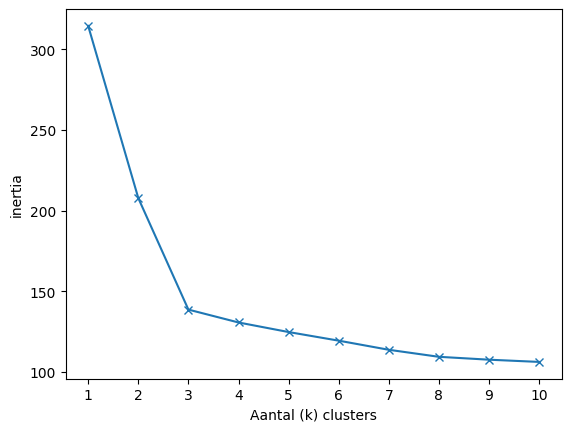

In [74]:
# overgenomen uit ml les
inertia = []
k = range(1, 11)

for i in k:
    model = KMeans(n_clusters=i, n_init=10)

    model.fit(df)

    inertia.append(model.inertia_)

plt.plot(k, inertia, '-x')
plt.xlabel('Aantal (k) clusters')
plt.ylabel('inertia')
plt.xticks(k)
plt.show()

hier kunnen we zien dat het elleboog op het punt k = 3 staat. dit betekent dat de beste aantal clusters 3 is.

In [75]:
data = df
data

,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,0.561027,...,0.833694,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893
1,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,0.421036,...,0.892147,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681
2,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,0.394422,...,0.666645,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171
3,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,1.000000,...,0.809051,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485
4,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402057,0.456909,0.020207,...,0.110577,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263711,0.243890,0.265539,0.359021,0.159503,0.468268,0.266454,0.704754,0.361255,0.358404,...,0.101925,0.050949,0.226399,0.622226,0.693546,0.459072,0.276723,0.567309,0.326597,0.329244
101,0.917984,0.889847,0.497698,0.499467,0.558340,0.483319,0.761525,0.645451,0.501318,0.455329,...,0.046845,0.746303,0.913696,0.645293,0.282011,0.376291,0.050440,0.469340,0.408466,0.714738
102,0.943256,0.970857,0.667814,0.794760,0.763969,0.727771,0.644381,0.533659,0.477373,0.326759,...,0.023429,0.749720,0.964501,0.373759,0.315903,0.546494,0.660520,0.155468,0.169731,0.744902
103,0.193191,0.080768,0.160092,0.553143,0.150116,0.016812,0.003486,0.402058,0.896680,0.238091,...,0.411653,0.001241,0.108823,0.000000,0.587919,0.992714,0.133532,0.632113,0.972459,0.069575


# Fantasy Cup Spelers Dataset

| Player    | Speed    | Defence     | Pas    | Shot     | Creativeness |
|-----------|----------|-------------|--------|----------|--------------|
| Vikram    | 90       | 70          | 80     | 75       | 85           |
| Bob       | 60       | 90          | 50     | 40       | 50           |
| Mark      | 80       | 65          | 90     | 70       | 80           |
| Sami      | 95       | 40          | 60     | 85       | 70           |
| Daan      | -        | 85          | -      | -        | -            |
| Penaldo   | 75       | 30          | 60     | 95       | 40           |
| Pessi     | 70       | 50          | 85     | 60       | 90           |




# Initialization:

Choose the number of clusters (K) that you want to create in your dataset.
Randomly initialize K cluster centroids. These centroids represent the initial centers of the clusters.
Assignment Step:

For each data point in the dataset, calculate the distance to each centroid.
Assign the data point to the cluster whose centroid is the closest using Euclidean distance,

Recalculate the centroids of each cluster by taking the mean of all data points assigned to that cluster.

Repeat the assignment and update steps until convergence. Convergence occurs when the centroids no longer change significantly or when a certain number of iterations are reached.
Output:

The algorithm outputs K clusters, each represented by its centroid.

note* even though Daan has NaN values he wil stil be asigned to a centroid based on existing features




In [76]:
class Clustering:
    def __init__(self, data):
        """
        Initializes the Clustering object with input data.

        Parameters:
        - data (numpy.ndarray): Input data for clustering.
        """
        self.data = data
        self.cluster_labels = None



        def calculate_silhouette_score(self):
            if self.cluster_labels is not None:
                if len(np.unique(self.cluster_labels)) > 1:
                    self.silhouette_score = silhouette_score(self.data, self.cluster_labels)
                else:
                    print("Silhouette score cannot be calculated with only one cluster.")
            else:
                print("Cluster labels not available. Run a clustering algorithm first.")

    def cluster_kmeans(self, n_clusters=3):
        """
        Performs KMeans clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_labels = kmeans.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_agglomerative(self, n_clusters=3):
        """
        Performs Agglomerative clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
        self.cluster_labels = agglomerative.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_dbscan(self, eps=0.5, min_samples=5):
        """
        Performs DBSCAN clustering on the input data.

        Parameters:
        - eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        - min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.cluster_labels = dbscan.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_birch(self, n_clusters=3):
        """
        Performs Birch clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        birch = Birch(n_clusters=n_clusters)
        self.cluster_labels = birch.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_meanshift(self, bandwidth=0.5):
        """
        Performs MeanShift clustering on the input data.

        Parameters:
        - bandwidth (float): Bandwidth parameter for MeanShift.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        meanshift = MeanShift(bandwidth=bandwidth)
        self.cluster_labels = meanshift.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))


In [77]:
unlabeled_data = data
unlabeled_data

,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,0.561027,...,0.833694,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893
1,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,0.421036,...,0.892147,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681
2,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,0.394422,...,0.666645,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171
3,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,1.000000,...,0.809051,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485
4,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402057,0.456909,0.020207,...,0.110577,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263711,0.243890,0.265539,0.359021,0.159503,0.468268,0.266454,0.704754,0.361255,0.358404,...,0.101925,0.050949,0.226399,0.622226,0.693546,0.459072,0.276723,0.567309,0.326597,0.329244
101,0.917984,0.889847,0.497698,0.499467,0.558340,0.483319,0.761525,0.645451,0.501318,0.455329,...,0.046845,0.746303,0.913696,0.645293,0.282011,0.376291,0.050440,0.469340,0.408466,0.714738
102,0.943256,0.970857,0.667814,0.794760,0.763969,0.727771,0.644381,0.533659,0.477373,0.326759,...,0.023429,0.749720,0.964501,0.373759,0.315903,0.546494,0.660520,0.155468,0.169731,0.744902
103,0.193191,0.080768,0.160092,0.553143,0.150116,0.016812,0.003486,0.402058,0.896680,0.238091,...,0.411653,0.001241,0.108823,0.000000,0.587919,0.992714,0.133532,0.632113,0.972459,0.069575


In [78]:
k = 3  

kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

unlabeled_data['cluster'] = kmeans.fit_predict(unlabeled_data)

print(unlabeled_data['cluster'].value_counts())

cluster
1    40
2    39
0    26
Name: count, dtype: int64


hier voeren we Kmeans op de unlabeled dataset en voegen de clusters toe als kolommen.

In [79]:
unlabeled_cluster = unlabeled_data.groupby('cluster').agg('mean')

display(unlabeled_cluster)


,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.523447,0.573262,0.556266,0.645412,0.599113,0.648855,0.666862,0.673735,0.685147,0.605894,...,0.883251,0.153669,0.552364,0.542640,0.341978,0.451951,0.441608,0.395708,0.413671,0.620927
1,0.234479,0.197888,0.223155,0.361775,0.196132,0.386166,0.210448,0.400807,0.288687,0.200952,...,0.337053,0.015374,0.197929,0.528294,0.626156,0.484505,0.415608,0.492764,0.430684,0.260223
2,0.826579,0.747882,0.424069,0.544913,0.483928,0.602510,0.586091,0.560396,0.512694,0.404926,...,0.067970,0.551744,0.782709,0.530890,0.376735,0.436866,0.419808,0.457613,0.418868,0.610555


In [80]:
labeled = labeled_df
display(labeled)

,filename,genre,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mel_spectral_contrast2_mean,mel_spectral_contrast3_mean,mel_spectral_contrast4_mean,mel_spectral_contrast5_mean,mel_spectral_contrast6_mean,mel_spectral_contrast7_mean,spectral_flatness,zcr,bandwith,centroid
8,m00002.wav,jazz,-298.807953,112.078224,6.485770,28.386517,-6.764679,16.651894,-11.809684,12.746783,...,6.739004,17.720329,31.856210,37.582171,36.234603,42.188263,0.001252,0.051222,1919.917650,1451.498371
9,m00039.wav,reggae,-169.243668,110.447716,-8.553957,43.898697,0.266454,26.646509,-14.365674,13.026837,...,8.001072,15.869485,22.225069,29.004593,27.931632,43.075836,0.004306,0.072178,2019.252686,1811.358216
43,m00041.wav,pop,-18.854591,71.328522,-3.743232,-1.396592,0.710348,-1.049137,-1.052407,-0.249471,...,5.718698,13.057337,17.657730,23.827369,27.071292,18.570913,0.078506,0.152910,2992.192112,3111.061099
29,m00072.wav,disco,-69.599335,83.059570,-16.599524,0.119469,7.415704,0.769619,1.337008,4.690686,...,6.370224,12.197484,18.810620,25.720595,24.686535,23.377385,0.038270,0.120259,2709.990169,2625.095044
34,m00096.wav,disco,-91.886307,87.604057,-2.058175,34.285538,-18.153368,19.344702,-14.697328,17.116173,...,4.989545,15.582052,20.384724,25.294628,29.771765,46.579812,0.009796,0.115890,2486.020650,2550.135384
48,m00102.wav,classical,-436.842346,154.113205,-19.859339,20.183603,3.164743,0.446392,-6.530639,-4.603338,...,8.704671,18.088766,26.164080,36.452103,37.462534,35.556624,0.000976,0.066325,1517.856160,1173.931066
25,m00112.wav,reggae,-265.694977,80.615921,9.722023,36.657085,27.836796,12.086828,15.014476,15.116937,...,3.927251,15.154408,20.473471,26.257647,25.445807,24.486615,0.026549,0.060883,2595.217468,2113.391953
4,m00138.wav,reggae,-198.632797,102.413567,-10.031449,30.802383,-3.310606,20.276924,-5.637373,28.095631,...,8.111595,11.985461,21.690643,26.647311,26.212014,47.129611,0.005168,0.070323,2295.466240,1995.600514
5,m00192.wav,classical,-85.264992,118.423058,-31.472771,20.282015,-4.417709,6.922598,-10.950942,-1.620085,...,5.707315,9.457773,16.339001,23.798978,26.500622,37.537164,0.010484,0.111613,1965.028715,1878.774030
22,m00206.wav,hiphop,-92.591652,77.412682,-32.756371,54.596119,-13.199195,33.656281,-12.085772,28.015388,...,3.856905,11.629413,12.605242,16.697020,17.101189,52.441041,0.018014,0.157603,2295.456105,2735.795802


In [81]:
label_scaled = scaler(labeled)

label_scaled['genre'] = labeled['genre']

label_scaled = label_scaled.groupby('genre').agg('mean', numeric_only=True)
# Drop 'index' en 'sfreq' kolommen

display(label_scaled)


,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
genre,,,,,,,,,,,,,,,,,,,,,
blues,0.570724,0.603191,0.568935,0.512389,0.612034,0.713023,0.611799,0.789955,0.630810,0.617932,...,0.696037,0.294558,0.595083,0.373805,0.533733,0.794573,0.513532,0.688573,0.437988,0.644441
classical,0.414737,0.380073,0.462212,0.307737,0.345461,0.437768,0.432761,0.529028,0.379019,0.562687,...,0.221291,0.153904,0.387208,0.551137,0.488247,0.597860,0.573020,0.710912,0.470433,0.392179
country,0.528854,0.527735,0.502125,0.568212,0.442093,0.674517,0.573105,0.680076,0.633341,0.541148,...,0.520322,0.291785,0.525166,0.222558,0.655681,0.693533,0.498192,0.733933,0.488153,0.533868
disco,0.539909,0.439278,0.620382,0.531246,0.503473,0.582386,0.525130,0.789353,0.553296,0.569495,...,0.372165,0.192389,0.474003,0.454328,0.598727,0.728963,0.396498,0.617229,0.441749,0.352991
hiphop,0.510468,0.462382,0.379884,0.378835,0.367477,0.552595,0.435395,0.474046,0.386888,0.513529,...,0.488845,0.244584,0.483315,0.347749,0.602565,0.637329,0.524570,0.590138,0.504995,0.434090
jazz,0.505609,0.470394,0.487221,0.416552,0.386641,0.413832,0.499157,0.746797,0.564836,0.518794,...,0.543609,0.194101,0.492837,0.363454,0.562417,0.721323,0.449418,0.583019,0.335821,0.462383
metal,0.549765,0.504264,0.439388,0.459322,0.412351,0.556741,0.431805,0.456267,0.461138,0.397431,...,0.342797,0.254174,0.515288,0.221448,0.647024,0.680236,0.644194,0.529290,0.368040,0.448331
pop,0.518554,0.508631,0.570681,0.543371,0.445909,0.539751,0.522993,0.705792,0.605422,0.568796,...,0.738439,0.112546,0.516186,0.328336,0.630846,0.700289,0.446648,0.649486,0.415466,0.506472
reggae,0.536363,0.484059,0.481324,0.469088,0.555118,0.779702,0.515746,0.643189,0.522847,0.576208,...,0.718651,0.100871,0.520251,0.323629,0.584332,0.674909,0.578131,0.577892,0.368364,0.427260


In [82]:
def bereken_afstanden(genre_data, cluster_data):
    afstanden = []

    for genre_row in genre_data.iterrows():
        genre_name, genre_values = genre_row
        for cluster_row in cluster_data.iterrows():
            cluster_name, cluster_values = cluster_row
            distance = euclidean(genre_values, cluster_values)
            afstanden.append((genre_name, cluster_name, distance))

    return afstanden

afstanden = bereken_afstanden(label_scaled, unlabeled_cluster)

for genre_name, cluster_name, distance in afstanden:
    print(f"Afstand tussen {genre_name} en {cluster_name}: {distance}")

Afstand tussen blues en 0: 1.0170016573606302
Afstand tussen blues en 1: 2.1937363750811985
Afstand tussen blues en 2: 1.6445935207530396
Afstand tussen classical en 0: 2.115576613094402
Afstand tussen classical en 1: 1.1269958877200712
Afstand tussen classical en 2: 1.5609093431683536
Afstand tussen country en 0: 1.5208884035631345
Afstand tussen country en 1: 1.7308268385530226
Afstand tussen country en 2: 1.5159580079251738
Afstand tussen disco en 0: 1.69918414962616
Afstand tussen disco en 1: 1.676771107817013
Afstand tussen disco en 2: 1.3301505395733544
Afstand tussen hiphop en 0: 1.8854796788190114
Afstand tussen hiphop en 1: 1.2754201399535074
Afstand tussen hiphop en 2: 1.3846956786394635
Afstand tussen jazz en 0: 1.566062229716932
Afstand tussen jazz en 1: 1.5318736376214896
Afstand tussen jazz en 2: 1.5465033725243793
Afstand tussen metal en 0: 2.1148332403696517
Afstand tussen metal en 1: 1.369041171761008
Afstand tussen metal en 2: 1.397694733439119
Afstand tussen pop en 0

In [83]:
def bereken_manhattan_afstanden(genre_data, cluster_data):
    afstanden = []

    for genre_row in genre_data.iterrows():
        genre_name, genre_values = genre_row
        for cluster_row in cluster_data.iterrows():
            cluster_name, cluster_values = cluster_row
            distance = cityblock(genre_values, cluster_values)
            afstanden.append((genre_name, cluster_name, distance))

    return afstanden

manhattan_afstanden = bereken_manhattan_afstanden(label_scaled, unlabeled_cluster)

for genre_name, cluster_name, distance in manhattan_afstanden:
    print(f"Manhattan-afstand tussen {genre_name} en {cluster_name}: {distance}")

Manhattan-afstand tussen blues en 0: 6.197687904040674
Manhattan-afstand tussen blues en 1: 15.136279314243453
Manhattan-afstand tussen blues en 2: 10.064613032487454
Manhattan-afstand tussen classical en 0: 14.356859140020758
Manhattan-afstand tussen classical en 1: 7.488214520171854
Manhattan-afstand tussen classical en 2: 10.219852567927074
Manhattan-afstand tussen country en 0: 10.048769366729822
Manhattan-afstand tussen country en 1: 11.661693772633141
Manhattan-afstand tussen country en 2: 9.742798376011205
Manhattan-afstand tussen disco en 0: 10.995293962323048
Manhattan-afstand tussen disco en 1: 11.014624405598846
Manhattan-afstand tussen disco en 2: 8.166064767283453
Manhattan-afstand tussen hiphop en 0: 12.61924738441188
Manhattan-afstand tussen hiphop en 1: 8.459395900592964
Manhattan-afstand tussen hiphop en 2: 8.692641309771636
Manhattan-afstand tussen jazz en 0: 10.339367666572729
Manhattan-afstand tussen jazz en 1: 10.07530230563972
Manhattan-afstand tussen jazz en 2: 9

In [84]:
def bepaal_genres_voor_clusters(genre_data, cluster_data, afstanden_functie):
    toewijzingen = []

    for cluster_row in cluster_data.iterrows():
        cluster_name, cluster_values = cluster_row
        min_afstand = float('inf') 
        op_een_na_min_afstand = float('inf')  
        toegewezen_genre = None
        op_een_na_toegewezen_genre = None

        for genre_row in genre_data.iterrows():
            genre_name, genre_values = genre_row
            afstand = afstanden_functie(genre_values, cluster_values)

            if afstand < min_afstand:
                op_een_na_min_afstand = min_afstand
                op_een_na_toegewezen_genre = toegewezen_genre

                min_afstand = afstand
                toegewezen_genre = genre_name
            elif afstand < op_een_na_min_afstand:
                op_een_na_min_afstand = afstand
                op_een_na_toegewezen_genre = genre_name

        toewijzingen.append((cluster_name, toegewezen_genre, min_afstand, op_een_na_toegewezen_genre, op_een_na_min_afstand))

    return toewijzingen

toewijzingen_euclidisch = bepaal_genres_voor_clusters(label_scaled, unlabeled_cluster, euclidean)

toewijzingen_manhattan = bepaal_genres_voor_clusters(label_scaled, unlabeled_cluster, cityblock)

print("Toewijzingen op basis van Euclidische afstanden:")
for cluster_name, genre_name, afstand, op_een_na_genre, op_een_na_afstand in toewijzingen_euclidisch:
    print(f"Cluster {cluster_name} is toegewezen aan genre {genre_name} met een afstand {afstand}. Op één na dichtstbijzijnde genre: {op_een_na_genre} met een afstand {op_een_na_afstand}")

print("\nToewijzingen op basis van Manhattan-afstanden:")
for cluster_name, genre_name, afstand, op_een_na_genre, op_een_na_afstand in toewijzingen_manhattan:
    print(f"Cluster {cluster_name} is toegewezen aan genre {genre_name} met een afstand {afstand}. Op één na dichtstbijzijnde genre: {op_een_na_genre} met een afstand {op_een_na_afstand}")

Toewijzingen op basis van Euclidische afstanden:
Cluster 0 is toegewezen aan genre blues met een afstand 1.0170016573606302. Op één na dichtstbijzijnde genre: pop met een afstand 1.1227778571672833
Cluster 1 is toegewezen aan genre classical met een afstand 1.1269958877200712. Op één na dichtstbijzijnde genre: rock met een afstand 1.1754147780332629
Cluster 2 is toegewezen aan genre disco met een afstand 1.3301505395733544. Op één na dichtstbijzijnde genre: hiphop met een afstand 1.3846956786394635

Toewijzingen op basis van Manhattan-afstanden:
Cluster 0 is toegewezen aan genre blues met een afstand 6.197687904040674. Op één na dichtstbijzijnde genre: pop met een afstand 7.1223362725644215
Cluster 1 is toegewezen aan genre classical met een afstand 7.488214520171854. Op één na dichtstbijzijnde genre: rock met een afstand 7.546079014548257
Cluster 2 is toegewezen aan genre disco met een afstand 8.166064767283453. Op één na dichtstbijzijnde genre: hiphop met een afstand 8.69264130977163

In [85]:
def plot_vis(data1, data2, x, y):


    plt.figure(figsize=(15, 6))

    sns.scatterplot(data=data1,
                    x=x,
                    y=y,
                    hue='cluster',
                    palette='viridis',
                    marker='o',  
                    legend='full')
    
    sns.scatterplot(data=data2,
                    x=x,
                    y=y,
                    hue='genre',
                    marker='D',  
                    legend='full')
    
    plt.title(f'Scatter Plot van {x} en {y} met Cluster- en Genrevergelijking')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


In [86]:
unlabeled_cluster.reset_index(inplace=True)
display(unlabeled_cluster.head())
label_scaled.reset_index(inplace=True)
display(label_scaled.head())

,cluster,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,0,0.523447,0.573262,0.556266,0.645412,0.599113,0.648855,0.666862,0.673735,0.685147,...,0.883251,0.153669,0.552364,0.542640,0.341978,0.451951,0.441608,0.395708,0.413671,0.620927
1,1,0.234479,0.197888,0.223155,0.361775,0.196132,0.386166,0.210448,0.400807,0.288687,...,0.337053,0.015374,0.197929,0.528294,0.626156,0.484505,0.415608,0.492764,0.430684,0.260223
2,2,0.826579,0.747882,0.424069,0.544913,0.483928,0.602510,0.586091,0.560396,0.512694,...,0.067970,0.551744,0.782709,0.530890,0.376735,0.436866,0.419808,0.457613,0.418868,0.610555


,genre,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,blues,0.570724,0.603191,0.568935,0.512389,0.612034,0.713023,0.611799,0.789955,0.630810,...,0.696037,0.294558,0.595083,0.373805,0.533733,0.794573,0.513532,0.688573,0.437988,0.644441
1,classical,0.414737,0.380073,0.462212,0.307737,0.345461,0.437768,0.432761,0.529028,0.379019,...,0.221291,0.153904,0.387208,0.551137,0.488247,0.597860,0.573020,0.710912,0.470433,0.392179
2,country,0.528854,0.527735,0.502125,0.568212,0.442093,0.674517,0.573105,0.680076,0.633341,...,0.520322,0.291785,0.525166,0.222558,0.655681,0.693533,0.498192,0.733933,0.488153,0.533868
3,disco,0.539909,0.439278,0.620382,0.531246,0.503473,0.582386,0.525130,0.789353,0.553296,...,0.372165,0.192389,0.474003,0.454328,0.598727,0.728963,0.396498,0.617229,0.441749,0.352991
4,hiphop,0.510468,0.462382,0.379884,0.378835,0.367477,0.552595,0.435395,0.474046,0.386888,...,0.488845,0.244584,0.483315,0.347749,0.602565,0.637329,0.524570,0.590138,0.504995,0.434090


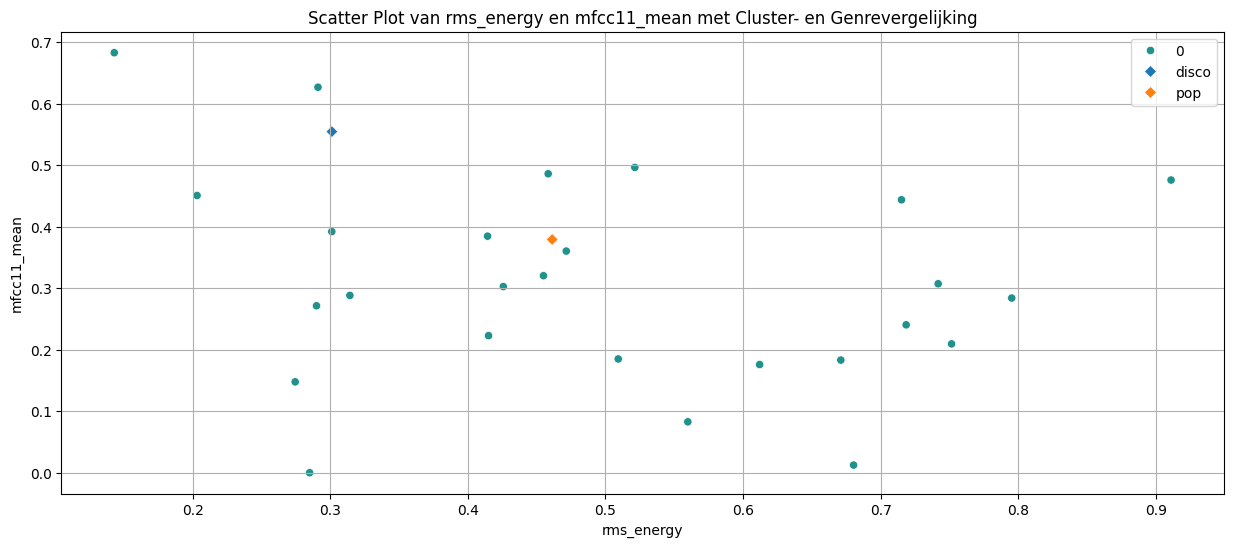

In [87]:
clusters = [0]

genres = ['disco', 'pop']


x = 'rms_energy'
y = 'mfcc11_mean'

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)


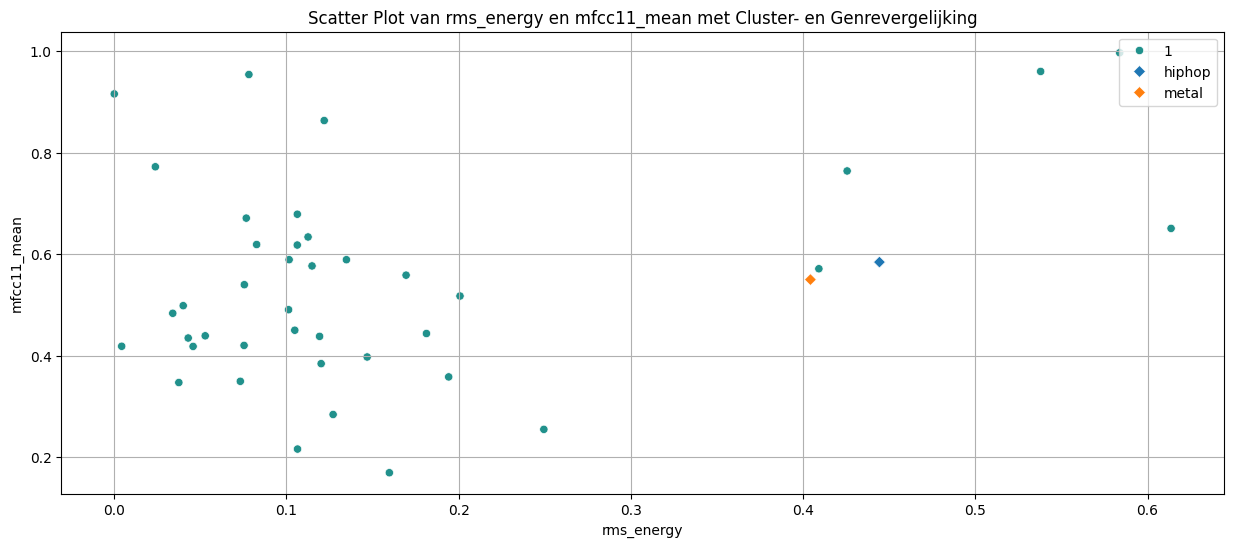

In [88]:
clusters = [1]

genres = ['metal', 'hiphop']

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)

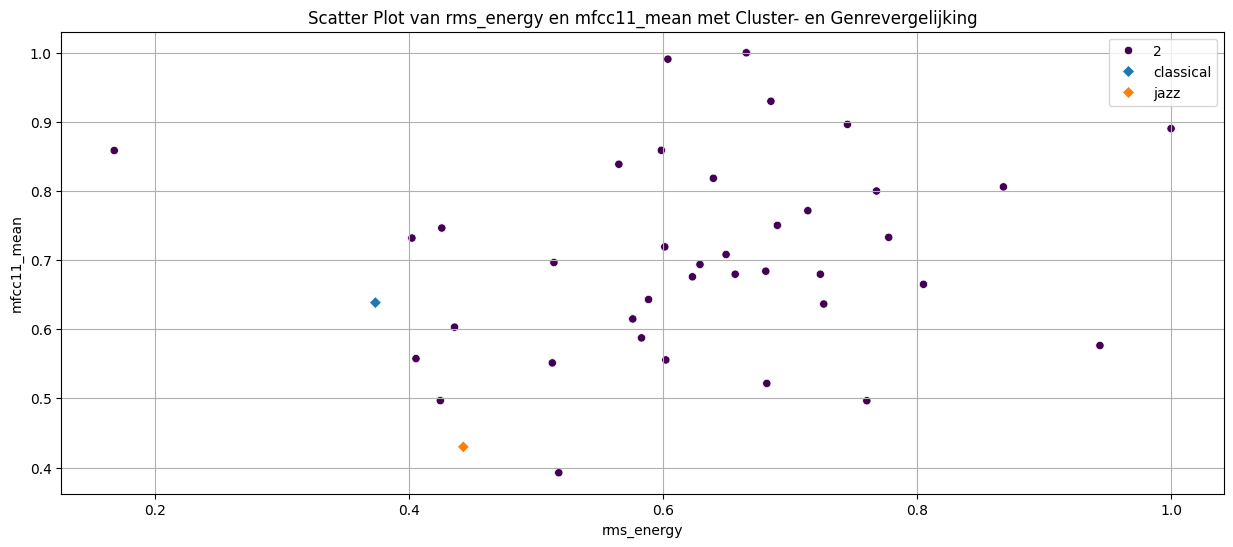

In [89]:
clusters = [2]

genres = ['jazz', 'classical']

x = 'rms_energy'
y = 'mfcc11_mean'

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)

# PCA Voorbeeld

Om een voorbeeld te geven van het uitvoeren van PCA hebben we eerst een dataset nodig. Voor het gemak maken wij gebruik van een kleine zelf verzonnen dataset.
|       |   X1   |   X2   |
|-------|:-----:|:-----:|
|   1   |   4   |   1   |
|   2   |   2   |   3   |
|   3   |   7   |   6   |
|   4   |   5   |   4   |
|   5   |   9   |   8   |


## Stap 1: Standaardiseren

De eerste stap voor het uitvoeren van PCA is het standaardiseren van de bovenstaande dataset. Dit doen wij aan de hand van de formule voor de Z-score. $$
Z = \frac{{X - \mu}}{{\sigma}}
$$

Door het toepassen van de Z-score krijgen wij de volgende gestandaardiseerde dataset:

|   | xz1  | xz2  |
|---|---------|---------|
| 1 | -0.6325 | -1.2649 |
| 2 | -1.2649 | 0       |
| 3 | 0.6325  | 0.6325  |
| 4 | 0       | -0.6325 |
| 5 | 1.8974  | 1.2649  |


## Stap 2: Covariantiematrix
Vervolgen bereken wij de covariantie matrix van de gestandaardiseerde dataset. Dit doen wij aan de hand van de volgende formule:

$$
Cov(X_i, X_j) = \frac{\sum_{k=1}^{n}(X_i^k - \bar{X_i})(X_j^k - \bar{X_j})}{n-1}
$$

Wanneer wij de bovenstaande formule toepassen krijgen wij het volgende matrix:

\begin{bmatrix} 6.75 & 0.5 \\ 0.5 & 5.0 \end{bmatrix}






## Stap 3: Eigenwaarden en Eigenvectoren
In stap 3 berekenen wij de eigenwaarden en eigenvectoren.

Eigenwaarden:
\begin{align*}
\lambda_1 &= 1.9 \\
\lambda_2 &= 0.8
\end{align*}



Eigenvectoren:
\begin{align*}
v_1 &= \begin{bmatrix} 0.84 \\ 
0.54 \end{bmatrix} \quad (\text{bij } \lambda_1) \\
v_2 &= \begin{bmatrix} -0.54 \\
0.84 \end{bmatrix} \quad (\text{bij } \lambda_2)
\end{align*}


## Stap 4: Feature vector
Wanneer we kijken naar stap 3 zien we dat vector 1 de meeste significantie heeft, dit is dus de vector met de hoogste eigenwaarde. We selecteren daarom v1 als ons eerst principal component. 
v_1 &= \begin{bmatrix} 0.84 \\ 
0.54 \end{bmatrix} 


## Stap 5: Projectie
Voor stap 5 gaan we de gestandaardiseerde gegevens vermenigvuldigen met de gekozen feature vector. Vervolgens krijgen de nieuwe dataset:
$$[-0.6325, -1.2649, -1.2649, 0.6325, 0.6325] \cdot [0.84, 0.54] = [-1.6326, -1.2649, -0.0810, 2.6305] $$
Zo komen wij tot een nieuwe dataset die is gereduceerd tot één dimensie, de eerste principale component.

|                       | Nieuwe Dataset |
|-----------------------|-----------------|
|           1           |     -1.6326     |
|           2           |     -1.2649     |
|           3           |     -0.0810     |
|           4           |      2.6305     |





Voor het uitvoeren van een simpele PCA hebben wij de stappen gevolgd die beschreven staan in het volgende artikel. (Jaadi, 2023) 

Nu dat wij een voorbeeld hebben gegeven van een simpele principal componenent analyse gaan wij dit nu uitvoeren op onze eigen dataset.


In [90]:


# Stap 1: Standaardiseren
#De data is eerder al gestandaardiseerd. Deze data kunnen we hier hergebruiken
scaled_df = data

In [91]:
# Stap 2: Covariantiematrix
# We maken een covariantiematrix aan de hand van no.cov
cov_matrix = np.cov(scaled_df, rowvar=False)

In [92]:
# Stap 3: Eigenwaarden en Eigenvectoren
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Nu sorteren wij de waardes
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]


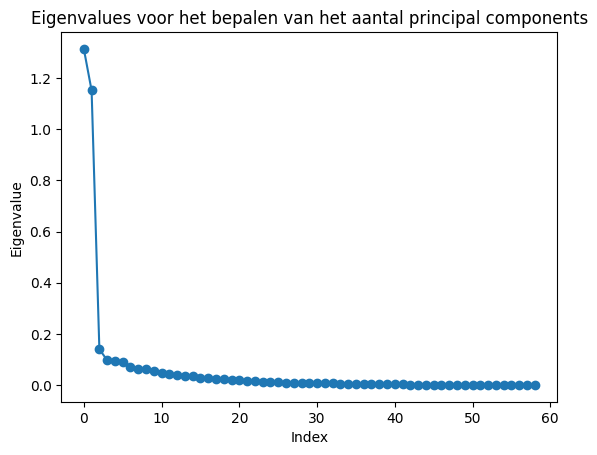

In [93]:
# Aantal principal compponents kiezen
plt.plot(eigenvalues, marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues voor het bepalen van het aantal principal components')
plt.show()


In [94]:
# Stap 4: Feature vector
pca_num = 3
principal_components = eigenvectors[:, -pca_num:]




In [95]:
# Stap 5: Projectie
pca = PCA(n_components=pca_num)
data_pca = pca.fit_transform(scaled_df)


In [96]:
# Resultaten toevoegen aan dataframe
unlabeld_new = unlabeled_data.copy()
for i in range(pca_num):
    unlabeld_new[f'PC{i+1}'] = data_pca[:, i]

In [97]:
# Toon het resultaat
display(unlabeled_data.head())


,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr,cluster
0,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,0.561027,...,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893,0
1,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,0.421036,...,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681,0
2,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,0.394422,...,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171,1
3,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,1.000000,...,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485,0
4,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402057,0.456909,0.020207,...,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807,1


In [98]:
#PCA toevoegen aan dataset
df_pca = scaled_df.copy()
for i in range(pca_num):
    df_pca[f'PC{i+1}'] = data_pca[:, i]

In [99]:
pca_df = df_pca[['PC1', 'PC2', 'PC3']]


In [100]:
#Getransformeerde dataset
display(pca_df.head())

,PC1,PC2,PC3
0,1.836866,-0.018815,0.010517
1,1.996875,0.314686,0.013659
2,0.181995,-1.041242,1.209566
3,1.909274,0.041188,-0.277533
4,-0.783876,-1.630182,-0.864740


Bronnen:
Bronnen lijst PCA Daan
Wikipedia-bijdragers. (2023, 31 juli). Hoofdcomponentenanalyse. Wikipedia. Geraadpleegd op 21-1-2024 van https://nl.wikipedia.org/wiki/Hoofdcomponentenanalyse 
Jaadi, Z. (2023, 29 maart). A Step-by-Step Explanation of Principal Component Analysis (PCA). Built In. Geraadpleegd op 21-1-2024 van https://builtin.com/data-science/step-step-explanation-principal-component-analysis
Beat and Tempo — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/beat.html
Filters — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/filters.html#filter-bank-construction
Librosa.feature.spectral_centroid — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_centroid.html
Librosa.feature.spectral_bandwidth — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_bandwidth.html
Librosa.feature.spectral_flatness — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_flatness.html
Librosa.feature.spectral_rolloff — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_rolloff.html
Librosa.feature.tonnetz — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html
Librosa.feature.zero_crossing_rate — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.zero_crossing_rate.html
Librosa.feature.Tempogram — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.tempogram.html
Scipy.spatial.distance.cityblock — SciPY v1.12.0 Manual. (z.d.). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html
Scipy.spatial.distance.euclidean — SciPY v1.12.0 manual. (z.d.). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html
Scipy.spatial.distance.euclidean — SciPY v1.12.0 manual. (z.d.-b). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html
Scipy.spatial.distance.cityblock — SciPY v1.12.0 Manual. (z.d.-b). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html

